In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
"""Split a series of netcdf"""
import xarray as xr
import pandas as pd
from datetime import timedelta
# from dask_jobqueue import SLURMCluster
# from dask.distributed import Client, LocalCluster, progress
from glob import glob
import os
from concurrent.futures import ProcessPoolExecutor

input_dir = '/global/cscratch1/sd/sbaldwin/highres_continuation/hourly_720x1440/'
output_dir = '/global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/'
input_dir_tmp = output_dir + 'tmp/'

In [4]:
ds_land = xr.open_dataset('/global/cscratch1/sd/crjones/highres_continuation/ne120_landfrac_720x1440.nc')

In [6]:
def subset_to_conus(ds, lons=[220, 300], lats=[20, 50],
                    transpose_dims=True, shift_time=True):
    ds_out = ds.sel(lat=slice(*lats), lon=slice(*lons))
    if shift_time:
        ds_out['time'] = ds_out['time'] + timedelta(days=365 * 2000)
    if transpose_dims:
        ds_out.transpose(*('time', 'lat', 'lon', 'nbnd'))
    return ds_out

In [7]:
ds_land_conus = subset_to_conus(ds_land, transpose_dims=False, shift_time=False)

In [8]:
ds_land_conus

<xarray.Dataset>
Dimensions:   (lat: 120, lon: 320)
Coordinates:
  * lat       (lat) float64 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * lon       (lon) float64 220.1 220.4 220.6 220.9 ... 299.1 299.4 299.6 299.9
Data variables:
    LANDFRAC  (lat, lon) float32 ...
Attributes:
    case:        earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.20190222
    map_file:    /global/homes/z/zender/data/maps/map_ne120np4_to_cmip6_720x1...
    input_file:  earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m_ANN_000101_00...

In [9]:
ds_land_conus.to_netcdf('/global/cscratch1/sd/crjones/highres_continuation/ne120_landfrac_720x1440.CONUS.nc')

In [ ]:
f_in = glob(f'{input_dir}*.nc')
ds0 = xr.open_dataset(f_in[0])

In [ ]:
ds0.attrs

In [168]:
def shift_time(ds, years=-100):
    ds['time'] = ds['time'] + timedelta(days=365 * years)

def start_date(ds):
    return ds.time[0].item().strftime('%Y-%m-%d')

def shift_and_write(file_in, years=-100, write_file=False):
    """Shifts file by n-years, changes file-name and writes to same directory"""
    with xr.open_dataset(file_in) as ds:
        original_start_date = start_date(ds)
        shift_time(ds, years=years)
        new_start_date = start_date(ds)
        file_out = file_in.replace(original_start_date, new_start_date)
        encoding = {v: {'zlib': True, 'complevel': 6} for v in ds}
        print('Input file:  ', file_in)
        print('Original date:  ', original_start_date)
        print('Output file:  ', file_out)
        print('New date:  ', new_start_date)
        print('\n')        
        if write_file:
            ds.to_netcdf(file_out, encoding=encoding)

In [169]:
for file_in in glob(f'{output_dir}*.nc')[0:10]:
    shift_and_write(file_in, years=-100, write_file=False)

Input file:   /global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_HR.ne120_oRRS18v3_ICG.cam.h5.2076-11-20.CONUS.nc
Original date:   2076-11-20
Output file:   /global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_HR.ne120_oRRS18v3_ICG.cam.h5.1976-11-20.CONUS.nc
New date:   1976-11-20


Input file:   /global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_HR.ne120_oRRS18v3_ICG.cam.h5.2068-07-03.CONUS.nc
Original date:   2068-07-03
Output file:   /global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_HR.ne120_oRRS18v3_ICG.cam.h5.1968-07-03.CONUS.nc
New date:   1968-07-03


Input file:   /global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_H

In [162]:
def shift_time(ds, years=-100):
    ds['time'] = ds['time'] + timedelta(days=365 * years)

In [165]:
shift_time(ds, 20)
print(ds['time'])

<xarray.DataArray 'time' (time: 720)>
array([cftime.DatetimeNoLeap(1966, 1, 1, 1, 0, 0, 0, 6, 1),
       cftime.DatetimeNoLeap(1966, 1, 1, 1, 59, 59, 999999, 6, 1),
       cftime.DatetimeNoLeap(1966, 1, 1, 3, 0, 0, 0, 6, 1), ...,
       cftime.DatetimeNoLeap(1966, 1, 30, 22, 0, 0, 0, 0, 30),
       cftime.DatetimeNoLeap(1966, 1, 30, 22, 59, 59, 999999, 0, 30),
       cftime.DatetimeNoLeap(1966, 1, 31, 0, 0, 0, 0, 1, 31)], dtype=object)
Coordinates:
  * time     (time) object 1966-01-01 01:00:00 ... 1966-01-31 00:00:00


In [158]:
ds['time'] = ds['time'] + timedelta(days=365*2000)

In [161]:
ds['time'] = ds['time'] + timedelta(days=365*(-100))
ds['time']

<xarray.DataArray 'time' (time: 720)>
array([cftime.DatetimeNoLeap(1906, 1, 1, 1, 0, 0, 0, 2, 1),
       cftime.DatetimeNoLeap(1906, 1, 1, 1, 59, 59, 999999, 2, 1),
       cftime.DatetimeNoLeap(1906, 1, 1, 3, 0, 0, 0, 2, 1), ...,
       cftime.DatetimeNoLeap(1906, 1, 30, 22, 0, 0, 0, 3, 30),
       cftime.DatetimeNoLeap(1906, 1, 30, 22, 59, 59, 999999, 3, 30),
       cftime.DatetimeNoLeap(1906, 1, 31, 0, 0, 0, 0, 4, 31)], dtype=object)
Coordinates:
  * time     (time) object 1906-01-01 01:00:00 ... 1906-01-31 00:00:00

In [13]:
def preprocess_last_times(flist):
    fnames = flist[:-1]
    fouts = flist[1:]
    for fname_in, ftemp_out in zip(fnames, fouts):
        file_name = os.path.split(ftemp_out)[-1]
        fname_out = f'{output_dir}{file_name.replace("-03600.nc", "-00000.nc")}'
        print(fname_in)
        print(fname_out)
        with xr.open_datset(fname_in) as ds:
            ds.isel(time=-1).to_netcdf(fname_out)

In [141]:
ds_a = xr.open_dataset(files_to_process[1])
ds_b = xr.open_dataset('/global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_HR.ne120_oRRS18v3_ICG.cam.h5.2056-02-15.CONUS.nc')

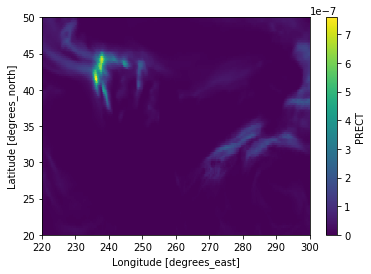

In [148]:
ds_a['PRECT'].sel(time='0056-02-15').sel(lon=slice(220, 300), lat=slice(20, 50)).mean(dim='time').plot()

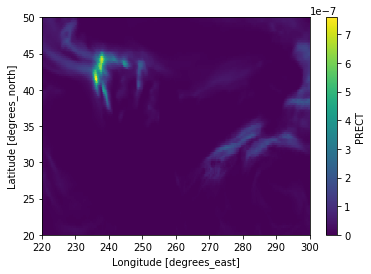

In [149]:
ds_b['PRECT'].mean(dim='time').plot()

In [150]:
da = ds_a['PRECT'].sel(time='0056-02-15').sel(lon=slice(220, 300), lat=slice(20, 50)).mean(dim='time')
db = ds_b['PRECT'].mean(dim='time')

In [155]:
import numpy as np

In [156]:
np.all(da == db)

<xarray.DataArray 'PRECT' ()>
array(True)

In [95]:
def select_dates(ds, nsamples=24):
    start_date = ds.time[0].item().strftime('%Y-%m-%d')
    end_date = ds.time[-1].item().strftime('%Y-%m-%d')
    the_dates = pd.date_range(start_date, end_date)
    the_dates = [d.strftime('%Y-%m-%d') for d in the_dates]
    return [d for d in the_dates if '-02-29' not in d and len(ds.sel(time=d).time) == nsamples]

In [96]:
select_dates(ds1)

['2056-01-31',
 '2056-02-01',
 '2056-02-02',
 '2056-02-03',
 '2056-02-04',
 '2056-02-05',
 '2056-02-06',
 '2056-02-07',
 '2056-02-08',
 '2056-02-09',
 '2056-02-10',
 '2056-02-11',
 '2056-02-12',
 '2056-02-13',
 '2056-02-14',
 '2056-02-15',
 '2056-02-16',
 '2056-02-17',
 '2056-02-18',
 '2056-02-19',
 '2056-02-20',
 '2056-02-21',
 '2056-02-22',
 '2056-02-23',
 '2056-02-24',
 '2056-02-25',
 '2056-02-26',
 '2056-02-27',
 '2056-02-28',
 '2056-03-01']

In [58]:
def output_name(file_in, new_date, add_conus=True):
    file_parts = file_in.split('.')
    # date is second to last
    file_parts[-2] = new_date
    if add_conus:
        file_parts[-1] = 'CONUS.nc'
    return '.'.join(file_parts)

In [62]:
output_name(file_name, '2056-07-01')

'theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_HR.ne120_oRRS18v3_ICG.cam.h5.2056-07-01.CONUS.nc'

In [53]:
the_dates = select_dates(dsx)

In [32]:
def subset_to_conus(ds, lons=[220, 300], lats=[20, 50],
                    transpose_dims=True, shift_time=True):
    ds_out = ds.sel(lat=slice(*lats), lon=slice(*lons))
    if shift_time:
        ds_out['time'] = ds_out['time'] + timedelta(days=365 * 2000)
    if transpose_dims:
        ds_out.transpose(*('time', 'lat', 'lon', 'nbnd'))
    return ds_out

# branch runs start at 03600 -- need to grab 00:00:00 from earlier file


def subset_and_write_to_file(fname, lons=[220, 300], lats=[20, 50],
                             transpose_dims=True, shift_time=True):
    print('Processing file ', fname)
    _, file_in = os.path.split(fname)  # get just the file name
    fout = f'{output_dir}{file_in.replace(".nc", ".CONUS.nc")}'
    print('Output file ', fout)
    
    # subset in space
    # ds = xr.open_dataset(fname).sel(lat=slice(*lats), lon=slice(*lons))
    # if shift_time:
    #     ds['time'] = ds['time'] + timedelta(days=365 * 2000)
    #     fout = fout.replace('h1.000', 'h1.200')
    # if transpose_dims:
    #     ds.transpose(*('time', 'lat', 'lon')).to_netcdf(fout)
    # else:
    #    ds.to_netcdf(fout)

def main(do_parallel=False):
    files_to_process = glob(f'{input_dir}*.nc')
    print(*sorted(files_to_process), sep='\n')

    if not do_parallel:
        subset_and_write_to_file(files_to_process[0])

    # dates_to_process given as 'yyyy-mm-dd'
    if do_parallel:
        with ProcessPoolExecutor(max_workers=8) as Executor:
            Executor.map(subset_and_write_to_file, files_to_process)

In [87]:
def load_file_test(f1, test=False):
    file_name = os.path.split(f1)[-1]
    f0 = input_dir_tmp + file_name.replace('-03600.nc', '-00000.nc')
    with (xr.open_mfdataset([f0, f1], data_vars='minimal') if os.path.isfile(f0) else xr.open_dataset(f1)) as ds:
        dsx = subset_to_conus(ds, transpose_dims=False).load()
    return dsx

In [89]:
ds1 = load_file_test(files_to_process[1])
ds1.time

<xarray.DataArray 'time' (time: 721)>
array([cftime.DatetimeNoLeap(2056, 1, 31, 0, 0, 0, 0, 0, 31),
       cftime.DatetimeNoLeap(2056, 1, 31, 1, 0, 0, 0, 0, 31),
       cftime.DatetimeNoLeap(2056, 1, 31, 1, 59, 59, 999999, 0, 31), ...,
       cftime.DatetimeNoLeap(2056, 3, 1, 22, 0, 0, 0, 1, 60),
       cftime.DatetimeNoLeap(2056, 3, 1, 22, 59, 59, 999999, 1, 60),
       cftime.DatetimeNoLeap(2056, 3, 2, 0, 0, 0, 0, 2, 61)], dtype=object)
Coordinates:
  * time     (time) object 2056-01-31 00:00:00 ... 2056-03-02 00:00:00

In [136]:
def split_subset_and_write(f1, test=False):
    file_name = os.path.split(f1)[-1]
    f0 = input_dir_tmp + file_name.replace('-03600.nc', '-00000.nc')
    with (xr.open_mfdataset([f0, f1], data_vars='minimal') if os.path.isfile(f0) else xr.open_dataset(f1)) as ds:
        dsx = subset_to_conus(ds, transpose_dims=False).load()
    the_dates = select_dates(dsx)
    # if test:
    print(dsx)
    print(the_dates)
    encoding = {v: {'zlib': True, 'complevel': 6} for v in dsx}
    for date in the_dates:
        if test:
            print(output_dir + output_name(file_name, date))
        else:
            dsx.sel(time=date).to_netcdf(output_dir + output_name(file_name, date), mode='w', encoding=encoding)

In [137]:
for f in files_to_reprocess:
    split_subset_and_write(f, test=False)

<xarray.Dataset>
Dimensions:    (lat: 120, lon: 320, nbnd: 2, time: 721)
Coordinates:
  * lat        (lat) float64 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * lon        (lon) float64 220.1 220.4 220.6 220.9 ... 299.1 299.4 299.6 299.9
  * time       (time) object 2056-01-31 00:00:00 ... 2056-03-02 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 20.0 20.25 20.25 20.5 ... 49.75 49.75 50.0
    lon_bnds   (lon, nbnd) float64 220.0 220.2 220.2 220.5 ... 299.8 299.8 300.0
    gw         (lat) float64 0.004097 0.00409 0.004084 ... 0.002827 0.002812
    area       (lat, lon) float64 1.788e-05 1.788e-05 ... 1.227e-05 1.227e-05
    FLUT       (time, lat, lon) float32 260.01245 252.55733 ... 204.52734
    PRECT      (time, lat, lon) float32 1.8985883e-08 ... 4.7055093e-10
    time_bnds  (time, nbnd) object 0056-01-30 22:59:59 ... 0056-03-02 00:00:00
Attributes:
    ne:                        120
    np:                        4
    Con

In [125]:
x1 = pd.date_range(start='2056-03-02', periods=30)

In [129]:
x1[0].month

3

In [124]:
'2' + files_to_process[3].split('.')[-2][1:10]

'2056-04-01'

In [140]:
previously_processed = sorted(glob(f'{output_dir}*.nc'))
previously_processed_dates = [f.split('.')[-3] for f in previously_processed]
ndays = 30
files_to_reprocess = []
for f in files_to_process[1:-1]:
    d0 = '2' + f.split('.')[-2][1:10]
    these_dates = pd.date_range(start=d0, periods=ndays)
    these_dates = [d.strftime('%Y-%m-%d') for d in these_dates if not (d.month == 2 and d.day == 29)]
    if any(d not in previously_processed_dates for d in these_dates):
        print('found something!')
        files_to_reprocess.append(f)
        print(f)
files_to_reprocess

[]

In [76]:
f1 = files_to_process[2]
file_name = os.path.split(f1)[-1]
f0 = input_dir_tmp + file_name.replace('-03600.nc', '-00000.nc')
print(f0)
print(f1)

/global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/tmp/theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_HR.ne120_oRRS18v3_ICG.cam.h5.0056-03-02-00000.nc
/global/cscratch1/sd/sbaldwin/highres_continuation/hourly_720x1440/theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_HR.ne120_oRRS18v3_ICG.cam.h5.0056-03-02-03600.nc


In [79]:
split_subset_and_write(f1, test=False)

In [72]:
select_dates(dsa)

['2056-03-02',
 '2056-03-03',
 '2056-03-04',
 '2056-03-05',
 '2056-03-06',
 '2056-03-07',
 '2056-03-08',
 '2056-03-09',
 '2056-03-10',
 '2056-03-11',
 '2056-03-12',
 '2056-03-13',
 '2056-03-14',
 '2056-03-15',
 '2056-03-16',
 '2056-03-17',
 '2056-03-18',
 '2056-03-19',
 '2056-03-20',
 '2056-03-21',
 '2056-03-22',
 '2056-03-23',
 '2056-03-24',
 '2056-03-25',
 '2056-03-26',
 '2056-03-27',
 '2056-03-28',
 '2056-03-29',
 '2056-03-30',
 '2056-03-31']

# Split files to daily

In [19]:
input_dir = '/global/cscratch1/sd/sbaldwin/highres_continuation/hourly_720x1440/'
output_dir = '/global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/'
input_dir_tmp = output_dir + 'tmp/'

In [23]:
f1 = files_to_process[1]
file_name = os.path.split(f1)[-1]
f0 = input_dir_tmp + file_name.replace('-03600.nc', '-00000.nc')
print(f0)

/global/cscratch1/sd/crjones/highres_continuation/hourly_720x1400/tmp/theta.20190910.branch_noCNT.n438b.unc03.A_WCYCL1950S_CMIP6_HR.ne120_oRRS18v3_ICG.cam.h5.0056-01-31-00000.nc


In [36]:
for f1 in files_to_process[0:1]:
    file_name = os.path.split(f1)[-1]
    f0 = input_dir_tmp + file_name.replace('-03600.nc', '-00000.nc')
    with (xr.open_mfdataset([f0, f1], data_vars='minimal') if os.path.isfile(f0) else xr.open_dataset(f1)) as ds:
        dsx = subset_to_conus(ds, transpose_dims=False).load()
        print(dsx)

<xarray.Dataset>
Dimensions:    (lat: 120, lon: 320, nbnd: 2, time: 720)
Coordinates:
  * lat        (lat) float64 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * lon        (lon) float64 220.1 220.4 220.6 220.9 ... 299.1 299.4 299.6 299.9
  * time       (time) object 2056-01-01 01:00:00 ... 2056-01-31 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 20.0 20.25 20.25 20.5 ... 49.75 49.75 50.0
    lon_bnds   (lon, nbnd) float64 220.0 220.2 220.2 220.5 ... 299.8 299.8 300.0
    gw         (lat) float64 0.004097 0.00409 0.004084 ... 0.002827 0.002812
    area       (lat, lon) float64 1.788e-05 1.788e-05 ... 1.227e-05 1.227e-05
    FLUT       (time, lat, lon) float32 285.8139 286.9027 ... 221.59543
    PRECT      (time, lat, lon) float32 9.734675e-09 ... 1.975757e-10
    time_bnds  (time, nbnd) object 0056-01-01 00:00:00 ... 0056-01-31 00:00:00
Attributes:
    ne:                        120
    np:                        4
    Convent

In [25]:
ds = xr.open_mfdataset([f0, f1], concat_dim='time') if os.path.isfile(f0) else xr.open_dataset(f1)
ds

<xarray.Dataset>
Dimensions:    (lat: 720, lon: 1440, nbnd: 2, time: 721)
Coordinates:
  * lat        (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon        (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time       (time) object 0056-01-31 00:00:00 ... 0056-03-02 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (time, lat, nbnd) float64 dask.array<shape=(721, 720, 2), chunksize=(1, 720, 2)>
    lon_bnds   (time, lon, nbnd) float64 dask.array<shape=(721, 1440, 2), chunksize=(1, 1440, 2)>
    gw         (time, lat) float64 dask.array<shape=(721, 720), chunksize=(1, 720)>
    area       (time, lat, lon) float64 dask.array<shape=(721, 720, 1440), chunksize=(1, 720, 1440)>
    FLUT       (lat, lon, time) float32 dask.array<shape=(720, 1440, 721), chunksize=(720, 1440, 1)>
    PRECT      (lat, lon, time) float32 dask.array<shape=(720, 1440, 721), chunksize=(720, 1440, 1)>
    time_bnds  (nbnd, time) object dask.array<

In [43]:
the_days = pd.date_range(day0, day1)
print(the_days)

DatetimeIndex(['2056-01-01', '2056-01-02', '2056-01-03', '2056-01-04',
               '2056-01-05', '2056-01-06', '2056-01-07', '2056-01-08',
               '2056-01-09', '2056-01-10', '2056-01-11', '2056-01-12',
               '2056-01-13', '2056-01-14', '2056-01-15', '2056-01-16',
               '2056-01-17', '2056-01-18', '2056-01-19', '2056-01-20',
               '2056-01-21', '2056-01-22', '2056-01-23', '2056-01-24',
               '2056-01-25', '2056-01-26', '2056-01-27', '2056-01-28',
               '2056-01-29', '2056-01-30', '2056-01-31'],
              dtype='datetime64[ns]', freq='D')


In [51]:
days, dsets = zip(*dsx.groupby('time.dayofyear'))

In [46]:
day0 = dsx.time[0].item().strftime('%Y-%m-%d')
day1 = dsx.time[-1].item().strftime('%Y-%m-%d')
print(day0, day1)

2056-01-01 2056-01-31
